In [1]:
!pip install wandb

In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import torch.nn.functional as F
import wandb
from torchsummary import summary
import torch
import torch.nn.functional as F
import numpy as np
import wandb
from skimage.metrics import structural_similarity as ssim
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import random_split
from tqdm import tqdm

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, latent_dim=64):  # Зменшено кількість каналів і латентний розмір
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # (597, 449)
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # (298, 225)
            nn.Conv2d(out_channels, 2 * out_channels, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # (150, 113)
        )
        
        self.flatten_size = 2 * out_channels * 150 * 113  # Оновлений розмір після MaxPool2d

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, latent_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, latent_dim=64):  # Зменшено кількість каналів і латентний розмір
        super().__init__()
        self.out_channels = out_channels
        
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 2 * out_channels * 150 * 113),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(2 * out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0),  # (300, 225)
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0),  # (600, 450)
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, in_channels, kernel_size=3, padding=1),  
            nn.Sigmoid(),  # Normalization output [0, 1]
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 2 * self.out_channels, 150, 113)
        x = self.conv(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder, device="cuda"):
        super().__init__()
        self.encoder = encoder
        self.encoder.to(device)
        self.decoder = decoder
        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [19]:
# class Encoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=8, latent_dim=100):
#         super().__init__()
        
#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # (597, 449)
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  
#             nn.ReLU(),
#             nn.Conv2d(out_channels, 2 * out_channels, kernel_size=3, stride=2, padding=1),  # (298, 225)
#             nn.ReLU(),
#             nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1),  
#             nn.ReLU(),
#             nn.Conv2d(2 * out_channels, 4 * out_channels, kernel_size=3, stride=2, padding=1),  # (150, 113)
#             nn.ReLU(),
#         )
        
#         self.flatten_size = 4 * out_channels * 150 * 113

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(self.flatten_size, latent_dim),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         x = self.net(x)
#         x = self.fc(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=8, latent_dim=100):
#         super().__init__()
#         self.out_channels = out_channels
        
#         self.fc = nn.Sequential(
#             nn.Linear(latent_dim, 4 * out_channels * 150 * 113),
#             nn.ReLU(),
#         )

#         self.conv = nn.Sequential(
#             nn.ConvTranspose2d(4 * out_channels, 2 * out_channels, kernel_size=3, stride=2, padding=1, output_padding=0),  # (300, 225)
#             nn.ReLU(),
#             nn.ConvTranspose2d(2 * out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0),  # (600, 450)
#             nn.ReLU(),
#             nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(out_channels, in_channels, kernel_size=3, padding=1),  
#             nn.Sigmoid(),  # Normalization output [0, 1]
#         )

#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 4 * self.out_channels, 150, 113)
#         x = self.conv(x)
#         return x

# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder, device="cuda"):
#         super().__init__()
#         self.encoder = encoder
#         self.encoder.to(device)
#         self.decoder = decoder
#         self.decoder.to(device)

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [4]:
# class Encoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=16, latent_dim=200):
#         super().__init__()
#         self.out_channels = out_channels

#         self.net = nn.Sequential( #  597x449
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # (600, 450)
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  
#             nn.ReLU(),
#             nn.Conv2d(out_channels, 2 * out_channels, kernel_size=3, stride=2, padding=1),  # (298, 225)
#             nn.ReLU(),
#             nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1),  
#             nn.ReLU(),
#             nn.Conv2d(2 * out_channels, 4 * out_channels, kernel_size=3, stride=2, padding=1),  # (150, 113)
#             nn.ReLU(),
#             nn.Conv2d(4 * out_channels, 4 * out_channels, kernel_size=3, padding=1),  
#             nn.ReLU(),
#         )
        
#         self.flatten_size = 4 * out_channels * 150 * 113

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(self.flatten_size, latent_dim),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         x = x.view(-1, 3, 597, 449)
#         x = self.net(x)
#         x = self.fc(x)
#         return x


# class Decoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=16, latent_dim=200):
#         super().__init__()
#         self.out_channels = out_channels

#         self.fc = nn.Sequential(
#             nn.Linear(latent_dim, 4 * out_channels * 150 * 113),
#             nn.ReLU(),
#         )

#         self.conv = nn.Sequential(
#             nn.ConvTranspose2d(4 * out_channels, 4 * out_channels, kernel_size=3, padding=1),  # (150, 113)
#             nn.ReLU(),
#             nn.ConvTranspose2d(4 * out_channels, 2 * out_channels, kernel_size=3, stride=2, padding=1, output_padding=0),  # (300, 225)
#             nn.ReLU(),
#             nn.ConvTranspose2d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1),  
#             nn.ReLU(),
#             nn.ConvTranspose2d(2 * out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0),  # (600, 450)
#             nn.ReLU(),
#             nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(out_channels, in_channels, kernel_size=3, padding=1),  
#             nn.Sigmoid(),  # Normalization output [0, 1]
#         )

#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 4 * self.out_channels, 150, 113)  # Відновлюємо форму для згорткових шарів
#         x = self.conv(x)
#         return x


# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder, device="cuda"):
#         super().__init__()
#         self.encoder = encoder
#         self.encoder.to(device)
#         self.decoder = decoder
#         self.decoder.to(device)

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


In [4]:
# Function to calculate the correlation coefficient
def correlation_coefficient(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    
    return numerator / denominator

# Function to calculate the threshold
def calculate_threshold(correlation_coeffs):
    mu_c = np.mean(correlation_coeffs)
    sigma_c = np.std(correlation_coeffs)
    threshold = mu_c - 0.5 * sigma_c
    return threshold

In [5]:
!wandb login 492953ddcda0576b6e6ebf89860aed0ccd177efe

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
run_name = f"Autoencoder simplier model out_channels=8, latent_dim=256, batch_size=32, lr=0.0001 MSELoss,epochs=20"

In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Skin cancer BASE model",

    # track hyperparameters and run metadata
    config={
    "epochs" : 20,
    "batch_size" : 32,
    "learning_rate" : 0.0001,
    },
    name=run_name
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kkaterynabilyk (kkaterynabilyk-lviv-polytechnic-national-university). Use `wandb login --relogin` to force relogin


In [8]:
config = wandb.config

In [9]:
class CustomDataset(Dataset):
    def __init__(self, folder_paths, transform=None, max_images=None):
        # Об'єднуємо шляхи до двох папок
        self.image_paths = []
        for folder_path in folder_paths:
            self.image_paths += [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.jpg') or fname.endswith('.png')]
        
        if max_images is not None:
            self.image_paths = self.image_paths[:max_images]  # Обмежуємо кількість зображень max_images
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert('RGB')
        image = np.array(image)
        if self.transform:
            # image = self.transform(image)
            image = self.transform(image=image)['image']
        return image

In [12]:
# Функція для обчислення PSNR
def psnr(target, prediction):
    mse = torch.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')  # Якщо зображення ідентичні
    max_pixel = 1.0  # Припускаємо, що значення нормалізовані між [0,1]
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))
    
def log_images_to_wandb(model, dataloader, device, num_images=2, tag="Train"):
    model.eval()
    for batch in dataloader:
        images = batch[0].to(device) if isinstance(batch, (tuple, list)) else batch.to(device)
        break

    num_images = min(num_images, images.shape[0])

    with torch.no_grad():
        reconstructed = model(images[:num_images])

    images = images[:num_images].permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()

    wandb_images = []
    for i in range(num_images):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(images[i])
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(reconstructed[i])
        axes[1].set_title("Reconstructed Image")
        axes[1].axis("off")

        plt.tight_layout()
        wandb_images.append(wandb.Image(fig, caption=f"{tag} Example {i + 1}"))
        plt.close(fig)

    wandb.log({f"{tag} Reconstructed Examples": wandb_images})

# Функція навчання автоенкодера
def train_autoencoder(model, dataset, criterion, optimizer, scheduler, device, epochs, val_split=0.15):
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        train_loss, train_psnr = 0.0, 0.0

        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for batch in pbar:
                images = batch[0].to(device) if isinstance(batch, (tuple, list)) else batch.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_psnr += psnr(images, outputs).item()
                pbar.set_postfix(loss=loss.item(), psnr=psnr(images, outputs).item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_psnr = train_psnr / len(train_loader)

        # Валідаційний етап
        model.eval()
        val_loss, val_psnr = 0.0, 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch[0].to(device) if isinstance(batch, (tuple, list)) else batch.to(device)
                outputs = model(images)

                val_loss += criterion(outputs, images).item()
                val_psnr += psnr(images, outputs).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_psnr = val_psnr / len(val_loader)

        # Логування результатів
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train PSNR: {avg_train_psnr:.2f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val PSNR: {avg_val_psnr:.2f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_psnr": avg_train_psnr,
            "val_loss": avg_val_loss,
            "val_psnr": avg_val_psnr
        })

        # Логування прикладів зображень
        log_images_to_wandb(model, train_loader, device, num_images=2, tag="Train")
        log_images_to_wandb(model, val_loader, device, num_images=2, tag="Validation")

        scheduler.step(avg_train_loss)

    return model
    
# def psnr(target, prediction):
#     """
#     Calculate the PSNR between the target and prediction.
#     """
#     mse = torch.mean((target - prediction) ** 2)
#     if mse == 0:
#         return float('inf')  # No error, images are identical
#     max_pixel = 1.0  # Assuming pixel values are normalized between [0, 1]
#     psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))
#     return psnr_value



# def log_images_to_wandb(model, dataloader, device, num_images=2):
#     """
#     Log original and reconstructed images to wandb.

#     Args:
#         model: The autoencoder model.
#         dataloader: The data loader.
#         device: The device (CPU or GPU).
#         num_images: Number of images to log.
#     """
#     model.eval()

#     # Get the first batch from the dataloader
#     for batch in dataloader:
#         if isinstance(batch, (tuple, list)):
#             images = batch[0]  # Extract images if dataset returns (images, labels)
#         else:
#             images = batch  # If dataset returns only images
#         images = images.to(device)
#         break  # Exit after the first batch

#     num_images = min(num_images, images.shape[0])  # Ensure num_images does not exceed batch_size

#     with torch.no_grad():
#         reconstructed = model(images[:num_images])  # Process only the required number of images

#     # Convert tensors to numpy
#     images = images[:num_images].permute(0, 2, 3, 1).cpu().numpy()
#     reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()

#     wandb_images = []
#     for i in range(num_images):
#         fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#         axes[0].imshow(images[i])
#         axes[0].set_title("Original Image")
#         axes[0].axis("off")

#         axes[1].imshow(reconstructed[i])
#         axes[1].set_title("Reconstructed Image")
#         axes[1].axis("off")

#         plt.tight_layout()

#         # Add to list of images
#         wandb_images.append(wandb.Image(fig, caption=f"Example {i + 1}"))

#         plt.close(fig)

#     # Log all images to wandb
#     wandb.log({"Reconstructed Examples": wandb_images})



# def train_autoencoder(model, dataloader, criterion, optimizer, scheduler, device, epochs):
#     """
#     Train the autoencoder with batch support and image logging to wandb.
#     """
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0
#         total_psnr = 0.0

#         # Use tqdm for progress tracking
#         with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
#             for batch_idx, data in enumerate(pbar):
#                 # Move data to the specified device (GPU/CPU)
#                 data = data.to(device)

#                 # Zero the gradients
#                 optimizer.zero_grad()

#                 # Perform the forward pass (prediction)
#                 output = model(data)

#                 # Calculate the loss
#                 loss = criterion(output, data)
#                 loss.backward()
#                 optimizer.step()

#                 # Aggregate metrics
#                 train_loss += loss.item()
#                 psnr_value = psnr(data, output)
#                 total_psnr += psnr_value.item()

#                 # Update tqdm progress bar with current loss and PSNR
#                 pbar.set_postfix(loss=loss.item(), psnr=psnr_value.item())
#                 #  # Log example images to wandb
#                 # log_images_to_wandb(model, dataloader, device, num_images=2)

#         # Calculate average loss and PSNR for the epoch
#         average_loss = train_loss / len(dataloader)
#         average_psnr = total_psnr / len(dataloader)

#         # Log metrics to the console
#         print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}, PSNR: {average_psnr:.2f}")
#         wandb.log({"epoch": epoch + 1, "loss": average_loss, "psnr": average_psnr})

#         # Log example images to wandb
#         log_images_to_wandb(model, dataloader, device, num_images=2)

#         # Update the learning rate scheduler
#         scheduler.step(average_loss)

#     return model


# # def train_autoencoder(model, dataloader, criterion, optimizer, scheduler, device, epochs):
# #     """
# #     Train the autoencoder with batch support.
# #     """
# #     for epoch in range(epochs):
# #         model.train()
# #         train_loss = 0.0
# #         total_psnr = 0.0

# #         # Use tqdm for progress tracking
# #         with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
# #             for batch_idx, data in enumerate(pbar):
# #                 # Move data to the specified device (GPU/CPU)
# #                 data = data.to(device)
# #                 # print(data.min(), data.max())  # Should be 0 and 1


# #                 # Zero the gradients
# #                 optimizer.zero_grad()

# #                 # Perform the forward pass (prediction)
# #                 output = model(data)
                
# #                 # Calculate the loss
# #                 loss = criterion(output, data)
# #                 loss.backward()
# #                 optimizer.step()

# #                 # Aggregate metrics
# #                 train_loss += loss.item()
# #                 psnr_value = psnr(data, output)
# #                 total_psnr += psnr_value.item()

# #                 # Update tqdm progress bar with current loss and PSNR
# #                 pbar.set_postfix(loss=loss.item(), psnr=psnr_value.item())

# #         # Calculate average loss and PSNR for the epoch
# #         average_loss = train_loss / len(dataloader)
# #         average_psnr = total_psnr / len(dataloader)

# #         # Log metrics to the console
# #         print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}, PSNR: {average_psnr:.2f}")
# #         wandb.log({"epoch": epoch + 1, "loss": average_loss, "psnr": average_psnr})

# #         # Update the learning rate scheduler
# #         scheduler.step(average_loss)

# #     return model




# # def train_autoencoder(model, dataloader, criterion, optimizer, scheduler, device, epochs):
# #     """
# #     Function to train the autoencoder.
    
# #     Args:
# #         model: The autoencoder model.
# #         dataloader: The data loader.
# #         criterion: The loss function.
# #         optimizer: The optimizer.
# #         scheduler: The learning rate scheduler.
# #         device: The device (CPU or GPU).
# #         epochs: The number of epochs.

# #     Returns:
# #         The model after training.
# #     """
# #     for epoch in range(epochs):
# #         model.train()
# #         train_loss = 0.0
# #         total_psnr = 0.0
# #         total_ssim = 0.0
        
# #         for data in dataloader:
# #             data = data.to(device)
            
            
# #             optimizer.zero_grad()
# #             output = model(data)
            
# #             # Resizing to avoid shape mismatch error
# #             data_resized = F.interpolate(data, size=(597, 449), mode='bicubic', align_corners=False)
            
# #             loss = criterion(output, data_resized)
# #             loss.backward()
# #             print(loss)
# #             optimizer.step()

# #             train_loss += loss.item()

# #             # Calculate PSNR and SSIM
# #             psnr_value = psnr(data_resized, output)
# #             total_psnr += psnr_value.item()

# #             # ssim_value = ssim(
# #             # data_resized.cpu().numpy().transpose(0, 2, 3, 1), 
# #             # output.cpu().detach().numpy().transpose(0, 2, 3, 1), 
# #             # win_size=7,  # Explicitly set the window size
# #             # channel_axis=-1  # Indicate that the last dimension is the channel axis
# #             # )
# #             # total_ssim += np.mean(ssim_value)

# #         # Average loss, PSNR, and SSIM for the epoch
# #         average_loss = train_loss / len(dataloader)
# #         average_psnr = total_psnr / len(dataloader)
# #         # average_ssim = total_ssim / len(dataloader)
        
# #         # # Output results
# #         # print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss}, PSNR: {average_psnr}, SSIM: {average_ssim}")
        
# #         # # Logging the metrics to wandb
# #         # wandb.log({"epoch": epoch + 1, "loss": average_loss, "psnr": average_psnr, "ssim": average_ssim})

# #         # Output results
# #         print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss}, PSNR: {average_psnr}")
        
# #         # Logging the metrics to wandb
# #         wandb.log({"epoch": epoch + 1, "loss": average_loss, "psnr": average_psnr})
        
        
# #         # Update learning rate
# #         scheduler.step(average_loss)

# #     return model

In [13]:
encoder = Encoder(in_channels=3, out_channels=8, latent_dim=100)
decoder = Decoder(in_channels=3, out_channels=8, latent_dim=100)
autoencoder_model = Autoencoder(encoder, decoder)

In [16]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.current_device())  # Should return the index of the current GPU


True
0


In [17]:
summary(autoencoder_model, (3, 597, 449))  # 597x449

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 597, 449]             224
              ReLU-2          [-1, 8, 597, 449]               0
            Conv2d-3          [-1, 8, 597, 449]             584
              ReLU-4          [-1, 8, 597, 449]               0
         MaxPool2d-5          [-1, 8, 299, 225]               0
            Conv2d-6         [-1, 16, 299, 225]           1,168
              ReLU-7         [-1, 16, 299, 225]               0
            Conv2d-8         [-1, 16, 299, 225]           2,320
              ReLU-9         [-1, 16, 299, 225]               0
        MaxPool2d-10         [-1, 16, 150, 113]               0
          Flatten-11               [-1, 271200]               0
           Linear-12                  [-1, 256]      69,427,456
             ReLU-13                  [-1, 256]               0
          Encoder-14                  [

In [18]:
# Data preparation
image_folder = "/kaggle/input/ham1000-segmentation-and-classification/images"  # Path to the folder containing images
merfed_image_folder = "/kaggle/input/synthetic-merged-moles/images"
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(height=597, width=449),
    A.Blur(blur_limit=1, p=0.3),  
    A.ShiftScaleRotate(shift_limit=0.05, rotate_limit=5, p=0.3, border_mode=cv2.BORDER_CONSTANT), 
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.3),
    A.ToFloat(max_value=255),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


dataset = CustomDataset([image_folder, merfed_image_folder], transform)
dataloader = DataLoader(dataset, batch_size=wandb.config.batch_size, shuffle=True)

# # Creating and training the autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [19]:
autoencoder = autoencoder_model.to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=wandb.config.learning_rate)
criterion = nn.MSELoss() 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Calling the training function
autoencoder = train_autoencoder(
    model=autoencoder,
    dataset=dataset,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=wandb.config.epochs
    
)

# Saving the model
torch.save(autoencoder, "cnn_autoencoder.pth")
wandb.save("cnn_autoencoder.pth")

Epoch 1/20: 100%|██████████| 293/293 [05:07<00:00,  1.05s/batch, loss=0.0193, psnr=17.1]


Epoch [1/20], Train Loss: 0.0351, Train PSNR: 14.75, Val Loss: 0.0236, Val PSNR: 16.29


Epoch 2/20: 100%|██████████| 293/293 [03:44<00:00,  1.31batch/s, loss=0.0138, psnr=18.6]


Epoch [2/20], Train Loss: 0.0199, Train PSNR: 17.06, Val Loss: 0.0167, Val PSNR: 17.81


Epoch 3/20: 100%|██████████| 293/293 [03:39<00:00,  1.34batch/s, loss=0.0087, psnr=20.6] 


Epoch [3/20], Train Loss: 0.0136, Train PSNR: 18.76, Val Loss: 0.0103, Val PSNR: 19.89


Epoch 4/20: 100%|██████████| 293/293 [03:40<00:00,  1.33batch/s, loss=0.00821, psnr=20.9]


Epoch [4/20], Train Loss: 0.0091, Train PSNR: 20.47, Val Loss: 0.0082, Val PSNR: 20.91


Epoch 5/20: 100%|██████████| 293/293 [03:39<00:00,  1.33batch/s, loss=0.00623, psnr=22.1]


Epoch [5/20], Train Loss: 0.0077, Train PSNR: 21.15, Val Loss: 0.0072, Val PSNR: 21.47


Epoch 6/20: 100%|██████████| 293/293 [03:39<00:00,  1.33batch/s, loss=0.00457, psnr=23.4]


Epoch [6/20], Train Loss: 0.0068, Train PSNR: 21.70, Val Loss: 0.0064, Val PSNR: 22.01


Epoch 7/20: 100%|██████████| 293/293 [03:40<00:00,  1.33batch/s, loss=0.00498, psnr=23]  


Epoch [7/20], Train Loss: 0.0062, Train PSNR: 22.09, Val Loss: 0.0061, Val PSNR: 22.18


Epoch 8/20: 100%|██████████| 293/293 [03:43<00:00,  1.31batch/s, loss=0.00548, psnr=22.6]


Epoch [8/20], Train Loss: 0.0058, Train PSNR: 22.39, Val Loss: 0.0058, Val PSNR: 22.42


Epoch 9/20: 100%|██████████| 293/293 [03:42<00:00,  1.32batch/s, loss=0.0048, psnr=23.2] 


Epoch [9/20], Train Loss: 0.0055, Train PSNR: 22.59, Val Loss: 0.0055, Val PSNR: 22.64


Epoch 10/20: 100%|██████████| 293/293 [03:40<00:00,  1.33batch/s, loss=0.00586, psnr=22.3]


Epoch [10/20], Train Loss: 0.0053, Train PSNR: 22.80, Val Loss: 0.0052, Val PSNR: 22.87


Epoch 11/20: 100%|██████████| 293/293 [03:40<00:00,  1.33batch/s, loss=0.0042, psnr=23.8] 


Epoch [11/20], Train Loss: 0.0050, Train PSNR: 23.02, Val Loss: 0.0049, Val PSNR: 23.10


Epoch 12/20: 100%|██████████| 293/293 [03:38<00:00,  1.34batch/s, loss=0.00455, psnr=23.4]


Epoch [12/20], Train Loss: 0.0048, Train PSNR: 23.22, Val Loss: 0.0047, Val PSNR: 23.30


Epoch 13/20: 100%|██████████| 293/293 [03:38<00:00,  1.34batch/s, loss=0.00461, psnr=23.4]


Epoch [13/20], Train Loss: 0.0046, Train PSNR: 23.39, Val Loss: 0.0046, Val PSNR: 23.42


Epoch 14/20: 100%|██████████| 293/293 [03:41<00:00,  1.33batch/s, loss=0.00411, psnr=23.9]


Epoch [14/20], Train Loss: 0.0045, Train PSNR: 23.55, Val Loss: 0.0043, Val PSNR: 23.66


Epoch 15/20: 100%|██████████| 293/293 [03:43<00:00,  1.31batch/s, loss=0.00331, psnr=24.8]


Epoch [15/20], Train Loss: 0.0043, Train PSNR: 23.67, Val Loss: 0.0043, Val PSNR: 23.71


Epoch 16/20: 100%|██████████| 293/293 [03:44<00:00,  1.31batch/s, loss=0.00447, psnr=23.5]


Epoch [16/20], Train Loss: 0.0042, Train PSNR: 23.80, Val Loss: 0.0042, Val PSNR: 23.81


Epoch 17/20: 100%|██████████| 293/293 [03:44<00:00,  1.30batch/s, loss=0.00374, psnr=24.3]


Epoch [17/20], Train Loss: 0.0041, Train PSNR: 23.89, Val Loss: 0.0041, Val PSNR: 23.90


Epoch 18/20: 100%|██████████| 293/293 [03:45<00:00,  1.30batch/s, loss=0.0035, psnr=24.6] 


Epoch [18/20], Train Loss: 0.0040, Train PSNR: 24.01, Val Loss: 0.0040, Val PSNR: 24.03


Epoch 19/20: 100%|██████████| 293/293 [03:43<00:00,  1.31batch/s, loss=0.00442, psnr=23.5]


Epoch [19/20], Train Loss: 0.0039, Train PSNR: 24.10, Val Loss: 0.0039, Val PSNR: 24.13


Epoch 20/20: 100%|██████████| 293/293 [03:43<00:00,  1.31batch/s, loss=0.00406, psnr=23.9]


Epoch [20/20], Train Loss: 0.0038, Train PSNR: 24.20, Val Loss: 0.0038, Val PSNR: 24.22


['/kaggle/working/wandb/run-20250327_170050-hac8ygk8/files/cnn_autoencoder.pth']

In [14]:
import wandb

# Ініціалізація W&B
api = wandb.Api()

# Отримання конкретного run
run = api.run("kkaterynabilyk-lviv-polytechnic-national-university/Skin cancer BASE model/f0i7jfk5")

# Завантаження файлу
file_name = "cnn_autoencoder.pth"  # Замінити на фактичну назву файлу
run.file(file_name).download(replace=True)

# Завантаження моделі (якщо це PyTorch)
import torch
state_dict = torch.load(file_name)
autoencoder_model.load_state_dict(state_dict)

/tmp/ipykernel_23/3478497942.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_name)


<All keys matched successfully>

In [15]:
summary(autoencoder_model, (3, 597, 449)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 597, 449]             224
              ReLU-2          [-1, 8, 597, 449]               0
            Conv2d-3          [-1, 8, 597, 449]             584
              ReLU-4          [-1, 8, 597, 449]               0
         MaxPool2d-5          [-1, 8, 299, 225]               0
            Conv2d-6         [-1, 16, 299, 225]           1,168
              ReLU-7         [-1, 16, 299, 225]               0
            Conv2d-8         [-1, 16, 299, 225]           2,320
              ReLU-9         [-1, 16, 299, 225]               0
        MaxPool2d-10         [-1, 16, 150, 113]               0
          Flatten-11               [-1, 271200]               0
           Linear-12                  [-1, 100]      27,120,100
             ReLU-13                  [-1, 100]               0
          Encoder-14                  [

In [25]:
import numpy as np
import torch
import torchvision.transforms as transforms
import albumentations as A
import cv2
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from torch.nn.functional import cosine_similarity

# Завантаження моделі та визначення пристрою (якщо ще не визначено)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Завантаження та конвертація зображення
test_image = Image.open("/kaggle/input/synthetic-merged-moles/images/synthetic_0017.jpg").convert('RGB')
test_image_np = np.array(test_image)  # Конвертація в numpy array

# Трансформації Albumentations
transform = A.Compose([
    A.Resize(height=597, width=449),
    A.Blur(blur_limit=1, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, rotate_limit=5, p=0.3, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.3),
    A.ToFloat(max_value=255),
])

# Застосування трансформації
test_image_transformed = transform(image=test_image_np)["image"]  # Albumentations повертає dict, беремо тільки "image"

# Конвертація в тензор PyTorch
test_image_tensor = torch.tensor(test_image_transformed, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (B, C, H, W)
test_image_tensor = test_image_tensor.to(device)  # Передаємо на той самий пристрій, що й модель

print(f"Shape of test image tensor: {test_image_tensor.shape}")  # Має бути (1, 3, 597, 449)

# Прогін через автоенкодер
output_image = autoencoder_model(test_image_tensor).detach().cpu().numpy()
print(output_image.shape)

print(f"Shape of output image tensor: {output_image.shape}")  # Має бути таким самим, як test_image_tensor

# Конвертуємо output_image і test_image_tensor до numpy для обчислень
original_np = test_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H, W, C)
reconstructed_np = output_image.squeeze(0).transpose(1, 2, 0)  # (H, W, C)

# Перевіряємо розміри зображення
H, W, C = original_np.shape

# Обираємо `win_size`, яке менше або рівне найменшій стороні зображення і є непарним
win_size = min(H, W)
if win_size % 2 == 0:  # Робимо його непарним
    win_size -= 1

# Обчислення MSE
mse_value = np.mean((original_np - reconstructed_np) ** 2)
print(f"MSE: {mse_value}")

# Обчислення SSIM з правильним win_size
ssim_value = ssim(original_np, reconstructed_np, data_range=1.0, channel_axis=2, win_size=win_size)
print(f"SSIM: {ssim_value}")

# Обчислення PSNR
psnr_value = cv2.PSNR(original_np, reconstructed_np)
print(f"PSNR: {psnr_value}")

# Обчислення Cosine Similarity між оригінальним і відновленим зображенням
# Перетворюємо зображення на одномірні вектори
original_flattened = original_np.flatten()
reconstructed_flattened = reconstructed_np.flatten()

# Косинусна подібність між векторами
cosine_sim = cosine_similarity(
    torch.tensor(original_flattened).unsqueeze(0).float(),
    torch.tensor(reconstructed_flattened).unsqueeze(0).float()
)

print(f"Cosine Similarity: {cosine_sim.item()}")


Shape of test image tensor: torch.Size([1, 3, 597, 449])
(1, 3, 597, 449)
Shape of output image tensor: (1, 3, 597, 449)
MSE: 0.00600604061037302
SSIM: 0.5414125323295593
PSNR: 70.34492170350683
Cosine Similarity: 0.9931161999702454


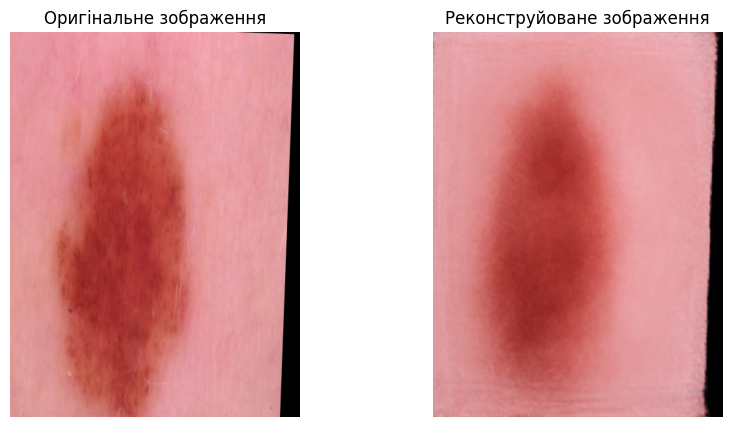

In [109]:
import matplotlib.pyplot as plt

# Конвертуємо в numpy для відображення
original_np = test_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (H, W, C)
reconstructed_np = output_image.squeeze(0).transpose(1, 2, 0)  # (H, W, C)

# Відображення
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_np)
axes[0].set_title("Оригінальне зображення")
axes[0].axis("off")

axes[1].imshow(reconstructed_np)
axes[1].set_title("Реконструйоване зображення")
axes[1].axis("off")

plt.show()
